# Linear Regression
### Parameters:
System:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
    * **speed** (*land speed*)
        * **other speeds**: fly, climb, swim
    * **num immunities**
    * **resistances**: fire, cold, electricity, acid, piercing, slashing, physical, bludgeoning, mental, poison, all-damage
    * **weaknesses**: cold-iron, good, fire, cold, area-damage, splash-damage, evil, slashing
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

Items
* **items**
    * **melee**
    * **ranged**
    * **spells nr**

### Prediction: *level*
## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "abomination-vaults-bestiary.db",
    "age-of-ashes-bestiary.db",
    "agents-of-edgewatch-bestiary.db",
    "april-fools-bestiary.db",
    "blog-bestiary.db",
    "blood-lords-bestiary.db",
    "book-of-the-dead-bestiary.db",
    "crown-of-the-kobold-king-bestiary.db",
    "extinction-curse-bestiary.db",
    "fall-of-plaguestone.db",
    "fists-of-the-ruby-phoenix-bestiary.db",
    "gatewalkers-bestiary.db",
    "impossible-lands-bestiary.db",
    "kingmaker-bestiary.db",
    "malevolence-bestiary.db",
    "menace-under-otari-bestiary.db",
    "monsters-of-myth-bestiary.db",
    "mwangi-expanse-bestiary.db",
    "night-of-the-gray-death-bestiary.db",
    "npc-gallery.db",
    "one-shot-bestiary.db",
    "outlaws-of-alkenstar-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
    "pathfinder-bestiary.db",
    "pathfinder-dark-archive.db",
    "pfs-introductions-bestiary.db",
    "pfs-season-1-bestiary.db",
    "pfs-season-2-bestiary.db",
    "pfs-season-3-bestiary.db",
    "pfs-season-4-bestiary.db",
    "quest-for-the-frozen-flame-bestiary.db",
    "shadows-at-sundown-bestiary.db",
    "strength-of-thousands-bestiary.db",
    "the-slithering-bestiary.db",
    "travel-guide-bestiary.db",
    "troubles-in-otari-bestiary.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
    "land_speed",
    "num_immunities",
    "fly",
    "swim",
    "climb",
    "fire_resistance",
    "cold_resistance",
    "electricity_resistance",
    "acid_resistance",
    "piercing_resistance",
    "slashing_resistance",
    "physical_resistance",
    "bludgeoning_resistance",
    "mental_resistance",
    "poison_resistance",
    "all-damage_resistance",
    "cold-iron_weakness",
    "good_weakness",
    "fire_weakness",
    "cold_weakness",
    "area-damage_weakness",
    "splash-damage_weakness",
    "evil_weakness",
    "slashing_weakness",
    "melee",
    "ranged",
    "spells",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3690 entries, 0 to 4327
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   level                   3690 non-null   int64  
 1   int                     3690 non-null   float64
 2   wis                     3690 non-null   float64
 3   reflex                  3690 non-null   float64
 4   land_speed              3690 non-null   float64
 5   book                    3690 non-null   object 
 6   cha                     3690 non-null   float64
 7   ac                      3690 non-null   float64
 8   con                     3690 non-null   float64
 9   will                    3690 non-null   float64
 10  dex                     3690 non-null   float64
 11  fortitude               3690 non-null   float64
 12  hp                      3690 non-null   int32  
 13  num_immunities          3690 non-null   int64  
 14  focus                   3690 non-null   

In [3]:
df.head()

,level,int,wis,reflex,land_speed,book,cha,ac,con,will,...,spells_nr_lvl_4,spells_nr_lvl_5,spells_nr_lvl_6,spells_nr_lvl_7,spells_nr_lvl_8,spells_nr_lvl_9,melee_max_bonus,avg_melee_dmg,ranged_max_bonus,avg_ranged_dmg
0,9,0.0,3.0,18.0,20.0,Pathfinder #165: Eyes of Empty Death,0.0,28.0,0.0,20.0,...,2,0,0,0,0,0,21,19.0,0,0.0
1,10,0.0,3.0,17.0,40.0,Pathfinder Abomination Vaults Hardcover Compil...,0.0,30.0,6.0,19.0,...,0,0,0,0,0,0,23,22.0,0,0.0
2,2,-2.0,3.0,11.0,30.0,Pathfinder #164: Hands of the Devil,1.0,17.0,1.0,9.0,...,0,0,0,0,0,0,9,6.5,8,6.5
3,8,0.0,3.0,16.0,30.0,Pathfinder #164: Hands of the Devil,1.0,27.0,3.0,15.0,...,0,0,0,0,0,0,20,18.0,20,9.5
4,9,2.0,4.0,21.0,0.0,Pathfinder #165: Eyes of Empty Death,2.0,31.0,0.0,18.0,...,0,0,0,0,0,0,17,21.5,0,0.0


## Preprocessing and train test split

In [4]:
from sklearn.preprocessing import MinMaxScaler


columns = [col for col in df.columns if col not in ["book", "level"]]
scaler = MinMaxScaler()
min_max_df = pd.DataFrame()
min_max_df[columns] = pd.DataFrame(scaler.fit_transform(df[columns]), index=df.index)
min_max_df["book"] = df["book"]
min_max_df["level"] = df["level"]

In [5]:
min_max_df.head()

,int,wis,reflex,land_speed,cha,ac,con,will,dex,fortitude,...,spells_nr_lvl_6,spells_nr_lvl_7,spells_nr_lvl_8,spells_nr_lvl_9,melee_max_bonus,avg_melee_dmg,ranged_max_bonus,avg_ranged_dmg,book,level
0,0.333333,0.470588,0.431818,0.166667,0.294118,0.509434,0.142857,0.416667,0.470588,0.319149,...,0.0,0.0,0.0,0.0,0.446809,0.333333,0.000000,0.000000,Pathfinder #165: Eyes of Empty Death,9
1,0.333333,0.470588,0.409091,0.333333,0.294118,0.547170,0.571429,0.395833,0.470588,0.468085,...,0.0,0.0,0.0,0.0,0.489362,0.385965,0.000000,0.000000,Pathfinder Abomination Vaults Hardcover Compil...,10
2,0.200000,0.470588,0.272727,0.250000,0.352941,0.301887,0.214286,0.187500,0.470588,0.148936,...,0.0,0.0,0.0,0.0,0.191489,0.114035,0.177778,0.106557,Pathfinder #164: Hands of the Devil,2
3,0.333333,0.470588,0.386364,0.250000,0.352941,0.490566,0.357143,0.312500,0.529412,0.361702,...,0.0,0.0,0.0,0.0,0.425532,0.315789,0.444444,0.155738,Pathfinder #164: Hands of the Devil,8
4,0.466667,0.529412,0.500000,0.000000,0.411765,0.566038,0.142857,0.375000,0.647059,0.297872,...,0.0,0.0,0.0,0.0,0.361702,0.377193,0.000000,0.000000,Pathfinder #165: Eyes of Empty Death,9


### Chronological split

In [6]:
from training.splitting_dataset import split_dataframe

os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(min_max_df, test_size=0.31)
os.chdir("../notebooks/models/linear_regression")

In [7]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

In [8]:
y_train = y_train.astype("int64")
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 1626 entries, 2574 to 1449
Series name: level
Non-Null Count  Dtype
--------------  -----
1626 non-null   int64
dtypes: int64(1)
memory usage: 25.4 KB


### Random split

In [9]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(min_max_df, chronological_split=False, test_size=0.25)

In [10]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## Linear Regression
### With chronological split

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


model = LinearRegression()
model.fit(X_train, y_train)
predict_train = model.predict(X_train)
predict = model.predict(X_test)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2 = r2_score(y_train, y_pred_train)
print(f"R2 score:{r2:.2f}")

R2 score:0.99


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse:.2f}")
print(f"MAE test: {mae:.2f}")

RMSE train: 0.54
RMSE test: 0.68
MAE test: 0.45


In [13]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "full", rmse, mae]

###### MAE by level

In [14]:
from training.results import plot_mae_by_level

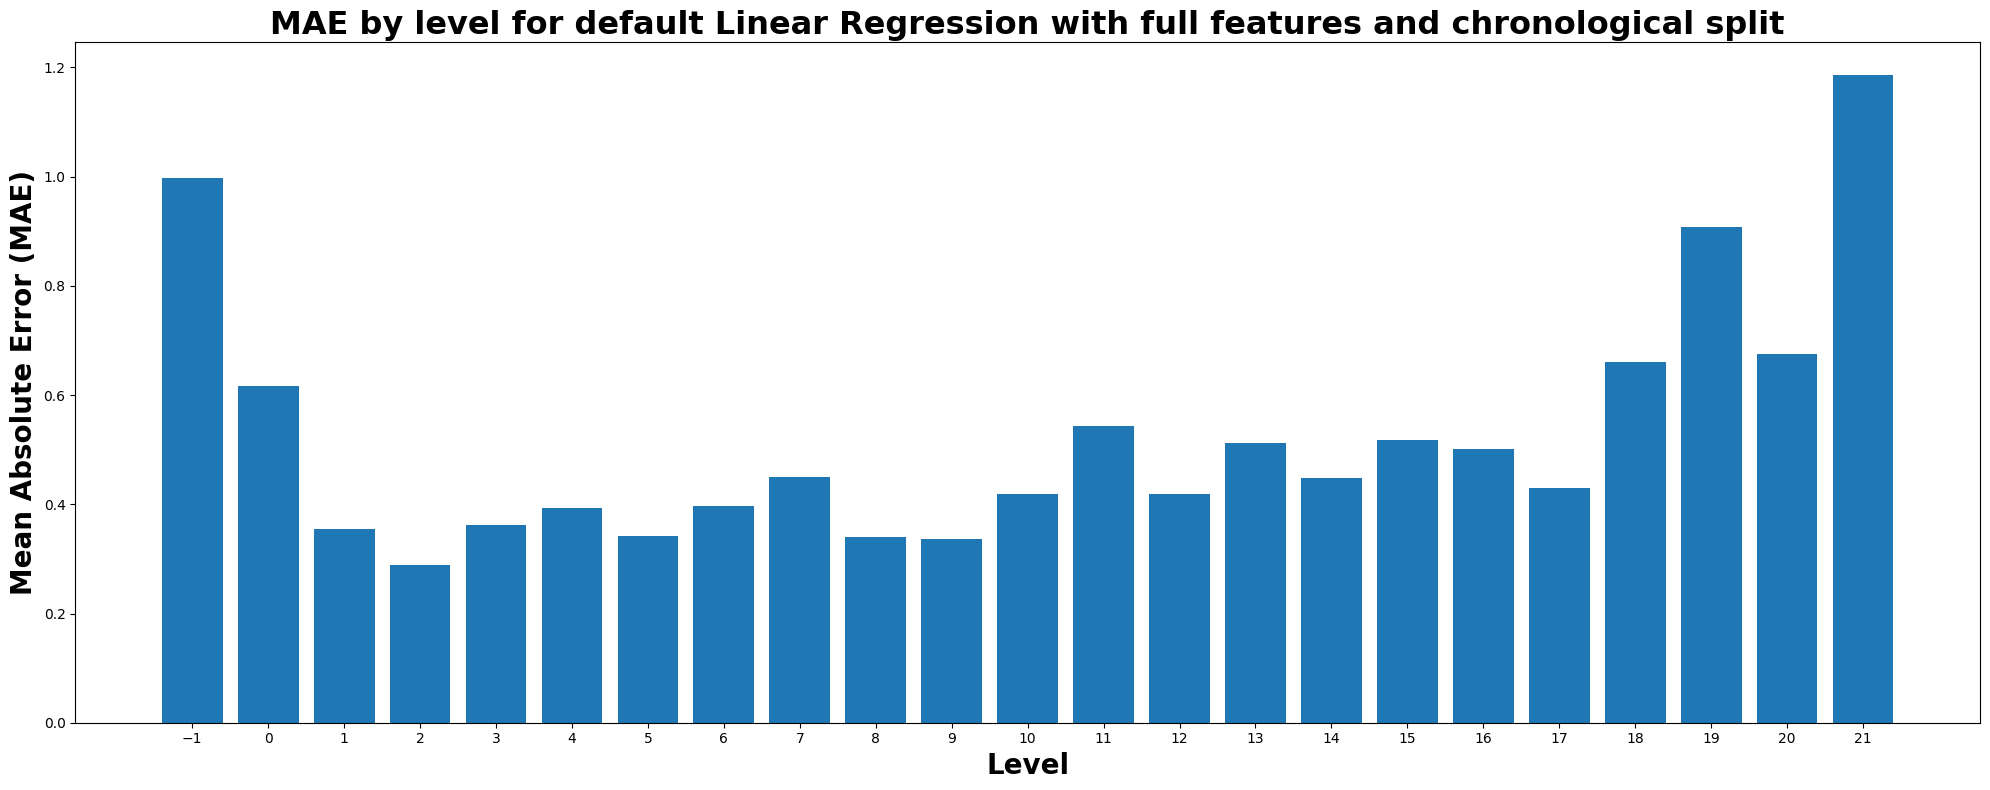

In [15]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default Linear Regression with full features and chronological split",
)

In [16]:
from training.results import evaluate_round_predictions, plot_confusion_matrix


evaluate_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.68

Round type: 0.5
RMSE: 0.69

Round type: 0.33
RMSE: 0.70

Round type: 0.45
RMSE: 0.68



In [17]:
predict[predict < -1] = -1
predict[predict > 21] = 21

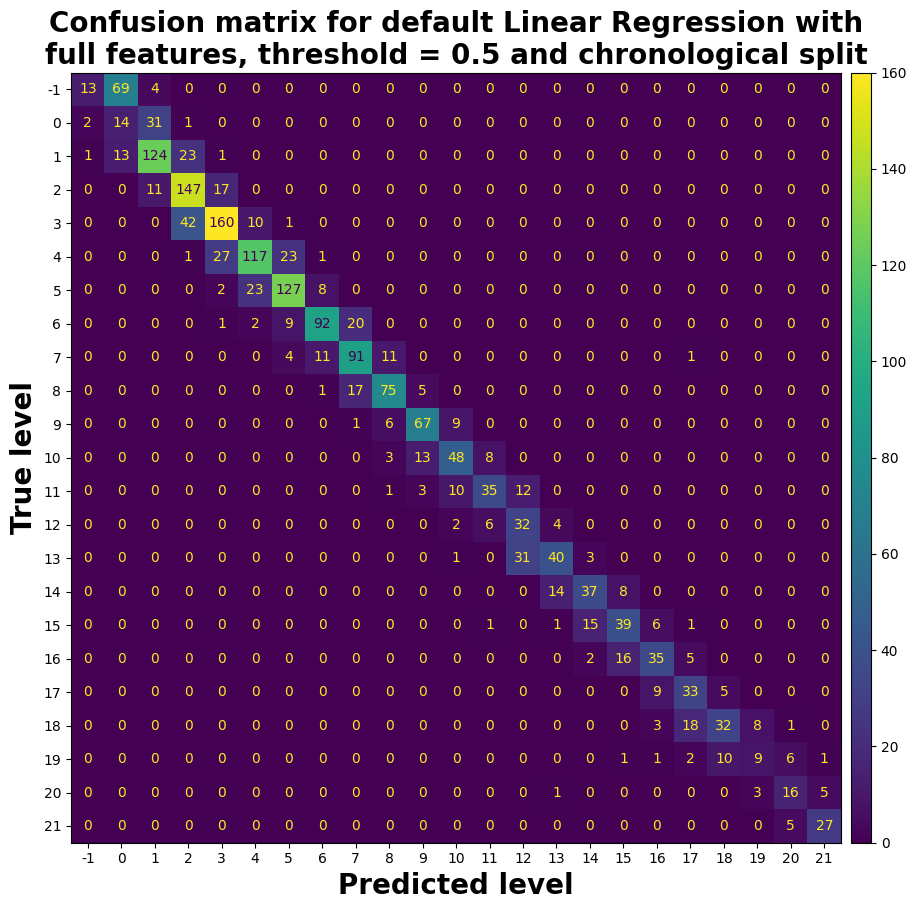

In [18]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for default Linear Regression with\nfull features, threshold = 0.5 and chronological split",
)

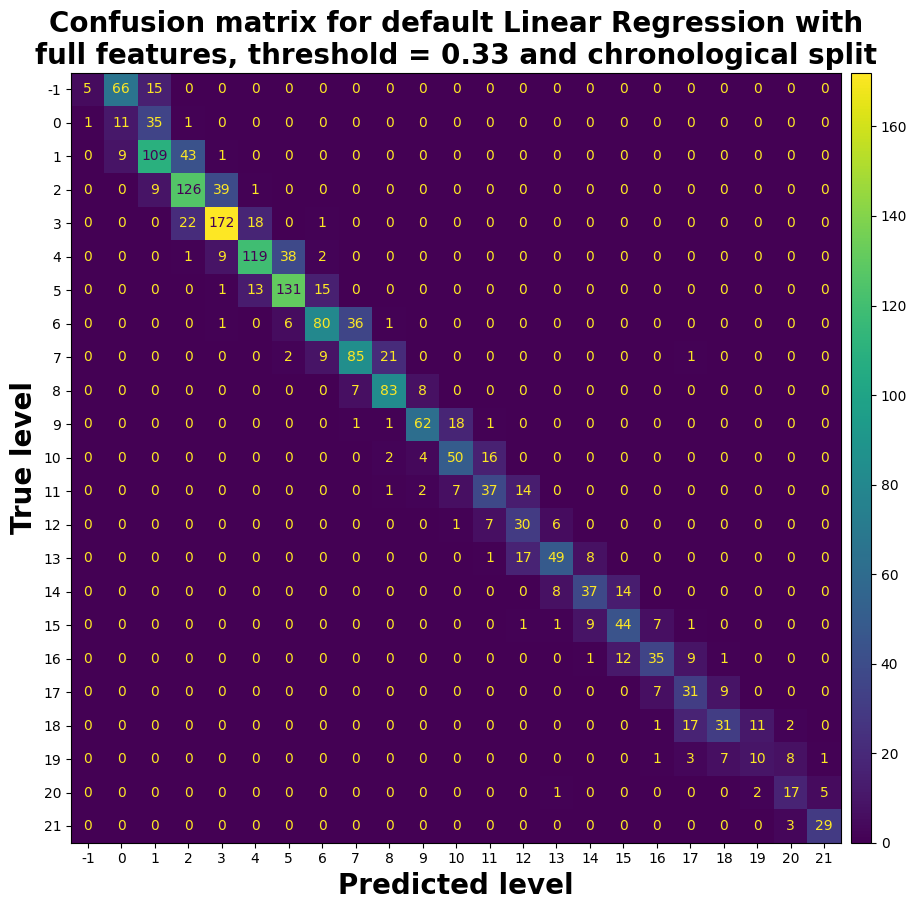

In [19]:
plot_confusion_matrix(
    predict,
    y_test,
    0.33,
    title="Confusion matrix for default Linear Regression with\nfull features, threshold = 0.33 and chronological split",
)

### With random split

In [20]:
model = LinearRegression()
model.fit(X_train_random_split, y_train_random_split)

y_pred_train_random_split = model.predict(X_train_random_split)
y_pred_test_random_split = model.predict(X_test_random_split)

r2 = r2_score(y_train_random_split, y_pred_train_random_split)
print(f"R2 score:{r2:.2f}")

R2 score:0.99


In [21]:
rmse_train = mean_squared_error(
    y_train_random_split, y_pred_train_random_split, squared=False
)
rmse = mean_squared_error(y_test_random_split, y_pred_test_random_split, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test_random_split)

print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse:.2f}")
print(f"MAE test: {mae:.2f}")

RMSE train: 0.61
RMSE test: 0.58
MAE test: 0.39


In [22]:
results.loc[1] = ["random", "default", "full", rmse, mae]

###### MAE by level

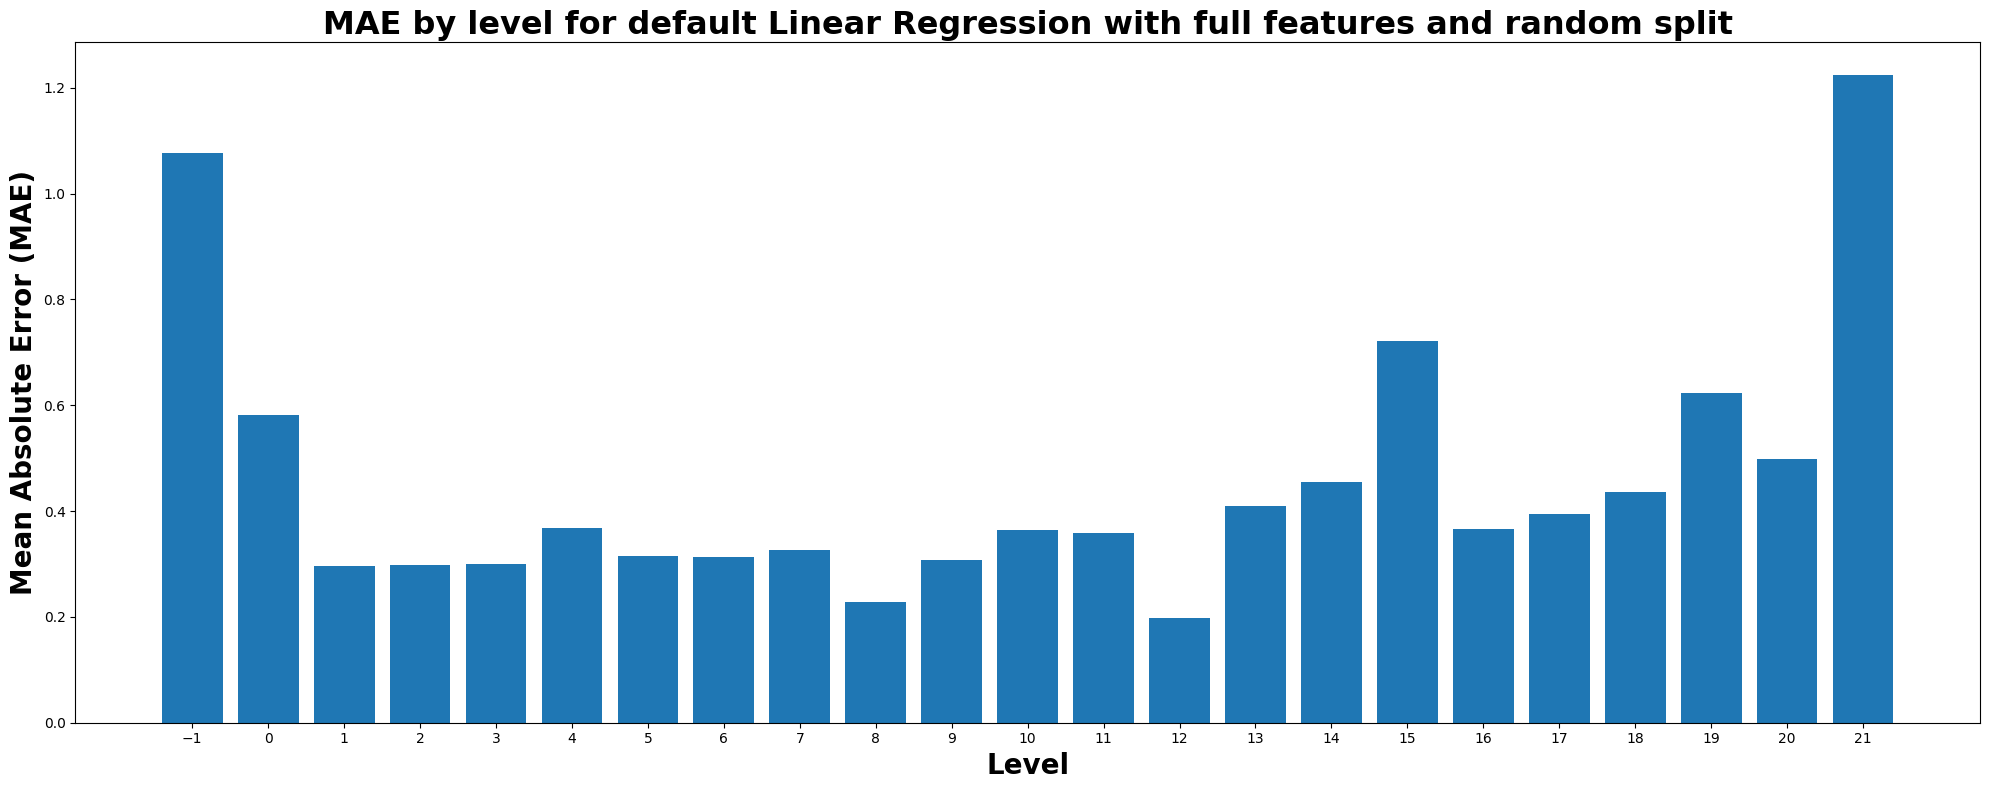

In [23]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test_random_split,
    title="MAE by level for default Linear Regression with full features and random split",
    export=True,
)

In [24]:
evaluate_round_predictions(
    [0.5, 0.33, 0.45], y_test_random_split, y_pred_test_random_split
)

Default:
RMSE: 0.58

Round type: 0.5
RMSE: 0.56

Round type: 0.33
RMSE: 0.60

Round type: 0.45
RMSE: 0.57



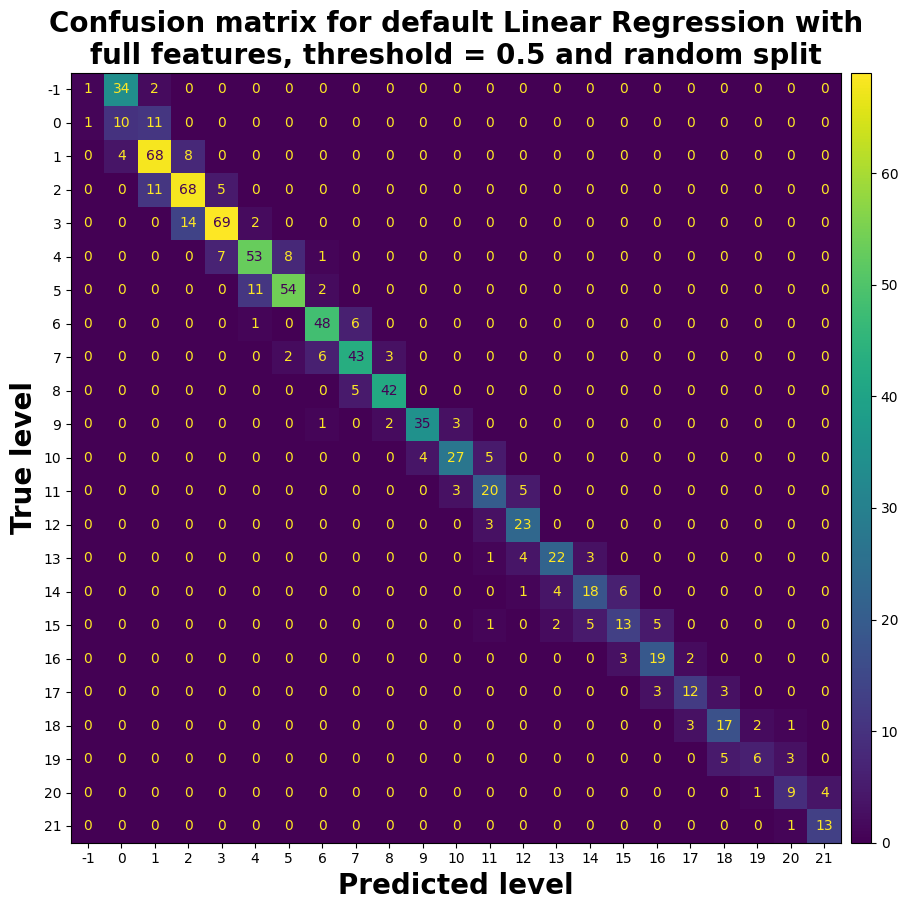

In [25]:
plot_confusion_matrix(
    y_pred_test_random_split,
    y_test_random_split,
    title="Confusion matrix for default Linear Regression with\nfull features, threshold = 0.5 and random split",
    export=True,
)

In [26]:
# print(y_pred_test_random_split)
indices = np.where(np.round(y_pred_test_random_split) == 11)
print(indices)
print(y_test_random_split.iloc[indices[0]])

(array([ 15,  48,  53,  84, 125, 169, 192, 203, 248, 273, 324, 336, 375,
       384, 482, 507, 516, 522, 527, 529, 546, 556, 565, 587, 642, 750,
       756, 765, 803, 816], dtype=int64),)
1058    15
54      11
2983    10
2674    11
2112    11
2474    11
4228    11
2765    11
1136    12
3007    11
2839    10
2798    11
934     12
2142    11
2644    11
706     11
1050    11
641     11
1960    11
918     10
2354    11
408     10
500     11
2009    11
2271    12
1566    11
2494    11
704     11
1967    13
844     10
Name: level, dtype: int64


In [27]:
print(X_test_random_split.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 162 to 1519
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   int                     923 non-null    float64
 1   wis                     923 non-null    float64
 2   reflex                  923 non-null    float64
 3   land_speed              923 non-null    float64
 4   cha                     923 non-null    float64
 5   ac                      923 non-null    float64
 6   con                     923 non-null    float64
 7   will                    923 non-null    float64
 8   dex                     923 non-null    float64
 9   fortitude               923 non-null    float64
 10  hp                      923 non-null    float64
 11  num_immunities          923 non-null    float64
 12  focus                   923 non-null    float64
 13  perception              923 non-null    float64
 14  str                     923 non-null   

In [28]:
print(X_test_random_split.loc[1058])

int                       0.066667
wis                       0.470588
reflex                    0.500000
land_speed                0.333333
cha                       0.470588
ac                        0.547170
con                       0.642857
will                      0.395833
dex                       0.588235
fortitude                 0.489362
hp                        0.332220
num_immunities            0.000000
focus                     0.000000
perception                0.226087
str                       0.823529
slashing_resistance       0.000000
bludgeoning_resistance    0.000000
cold_resistance           0.000000
piercing_resistance       0.000000
physical_resistance       0.000000
mental_resistance         0.000000
all-damage_resistance     0.000000
acid_resistance           0.000000
electricity_resistance    0.000000
poison_resistance         0.000000
fire_resistance           0.000000
good_weakness             0.000000
cold_weakness             0.000000
area-damage_weakness

In [29]:
print(df.iloc[1058])

level                                       14
int                                        4.0
wis                                        4.0
reflex                                    24.0
land_speed                                30.0
book                      Pathfinder Kingmaker
cha                                        6.0
ac                                        36.0
con                                        6.0
will                                      24.0
dex                                        4.0
fortitude                                 28.0
hp                                         225
num_immunities                               0
focus                                        1
perception                                26.0
str                                        8.0
slashing_resistance                          0
bludgeoning_resistance                       0
cold_resistance                              0
piercing_resistance                          0
physical_resi

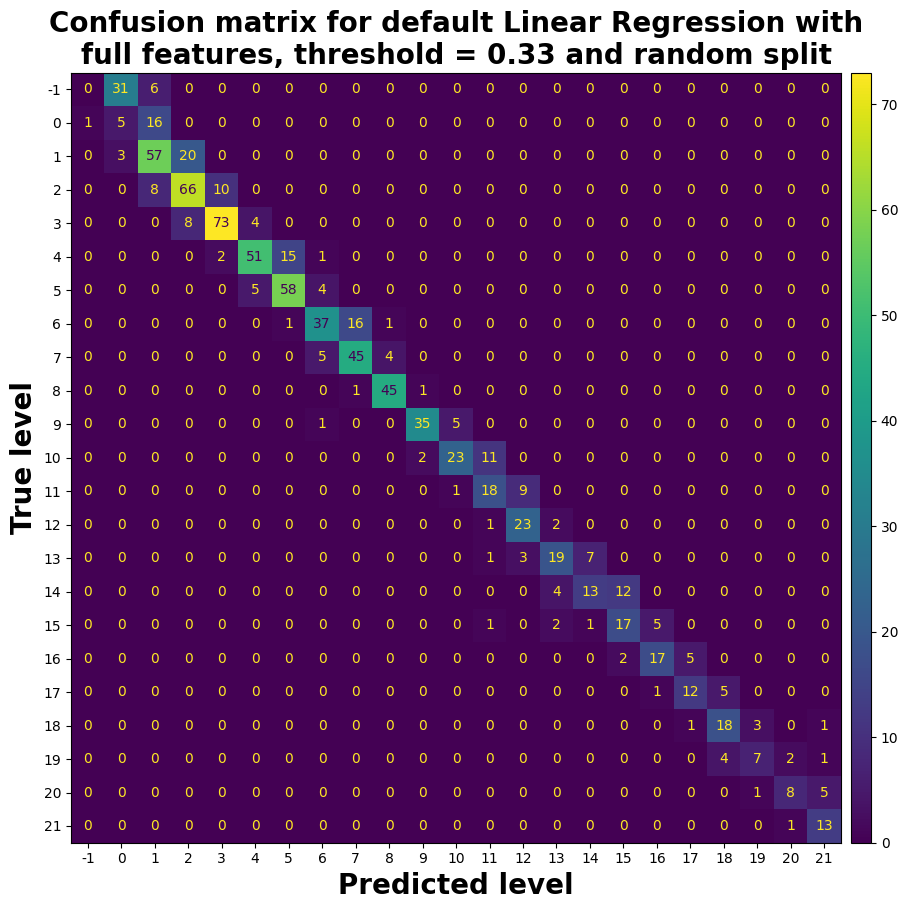

In [30]:
plot_confusion_matrix(
    y_pred_test_random_split,
    y_test_random_split,
    0.33,
    title="Confusion matrix for default Linear Regression with\nfull features, threshold = 0.33 and random split",
)

## Tuning (ridge, LASSO)

### With chronological split

In [31]:
from sklearn.linear_model import RidgeCV, LassoCV
from training.results import assess_regression_model


reg_ridge_cv = RidgeCV(alphas=np.linspace(0.1, 100, 1000))
reg_lasso_cv = LassoCV(n_alphas=1000, random_state=0)

reg_ridge_cv = reg_ridge_cv.fit(X_train, y_train)
reg_lasso_cv = reg_lasso_cv.fit(
    X_train,
    np.array(y_train).reshape(
        y_train.size,
    ),
)

reg_linear = LinearRegression()
reg_linear.fit(X_train, y_train)

print(f"Ridge CV alpha: {reg_ridge_cv.alpha_:.4f}")
print(f"Lasso CV alpha: {reg_lasso_cv.alpha_:.4f}")
print()

print("Linear Regression")
assess_regression_model(reg_linear, X_train, X_test, y_train, y_test, r2=True)

print("Ridge:")
rmse, mae = assess_regression_model(
    reg_ridge_cv, X_train, X_test, y_train, y_test, r2=True
)
results.loc[2] = ["chronological", "Ridge", "full", rmse, mae]

print("Lasso:")
rmse, mae = assess_regression_model(
    reg_lasso_cv, X_train, X_test, y_train, y_test, r2=True
)
results.loc[3] = ["chronological", "Lasso", "full", rmse, mae]

Ridge CV alpha: 0.6000
Lasso CV alpha: 0.0011

Linear Regression
R2: 0.99
RMSE train: 0.54
RMSE test: 0.68
MAE test: 0.45

Ridge:
R2: 0.99
RMSE train: 0.54
RMSE test: 0.67
MAE test: 0.46

Lasso:
R2: 0.99
RMSE train: 0.55
RMSE test: 0.67
MAE test: 0.45



###### MAE by level Ridge

In [32]:
y_pred_test = reg_ridge_cv.predict(X_test)

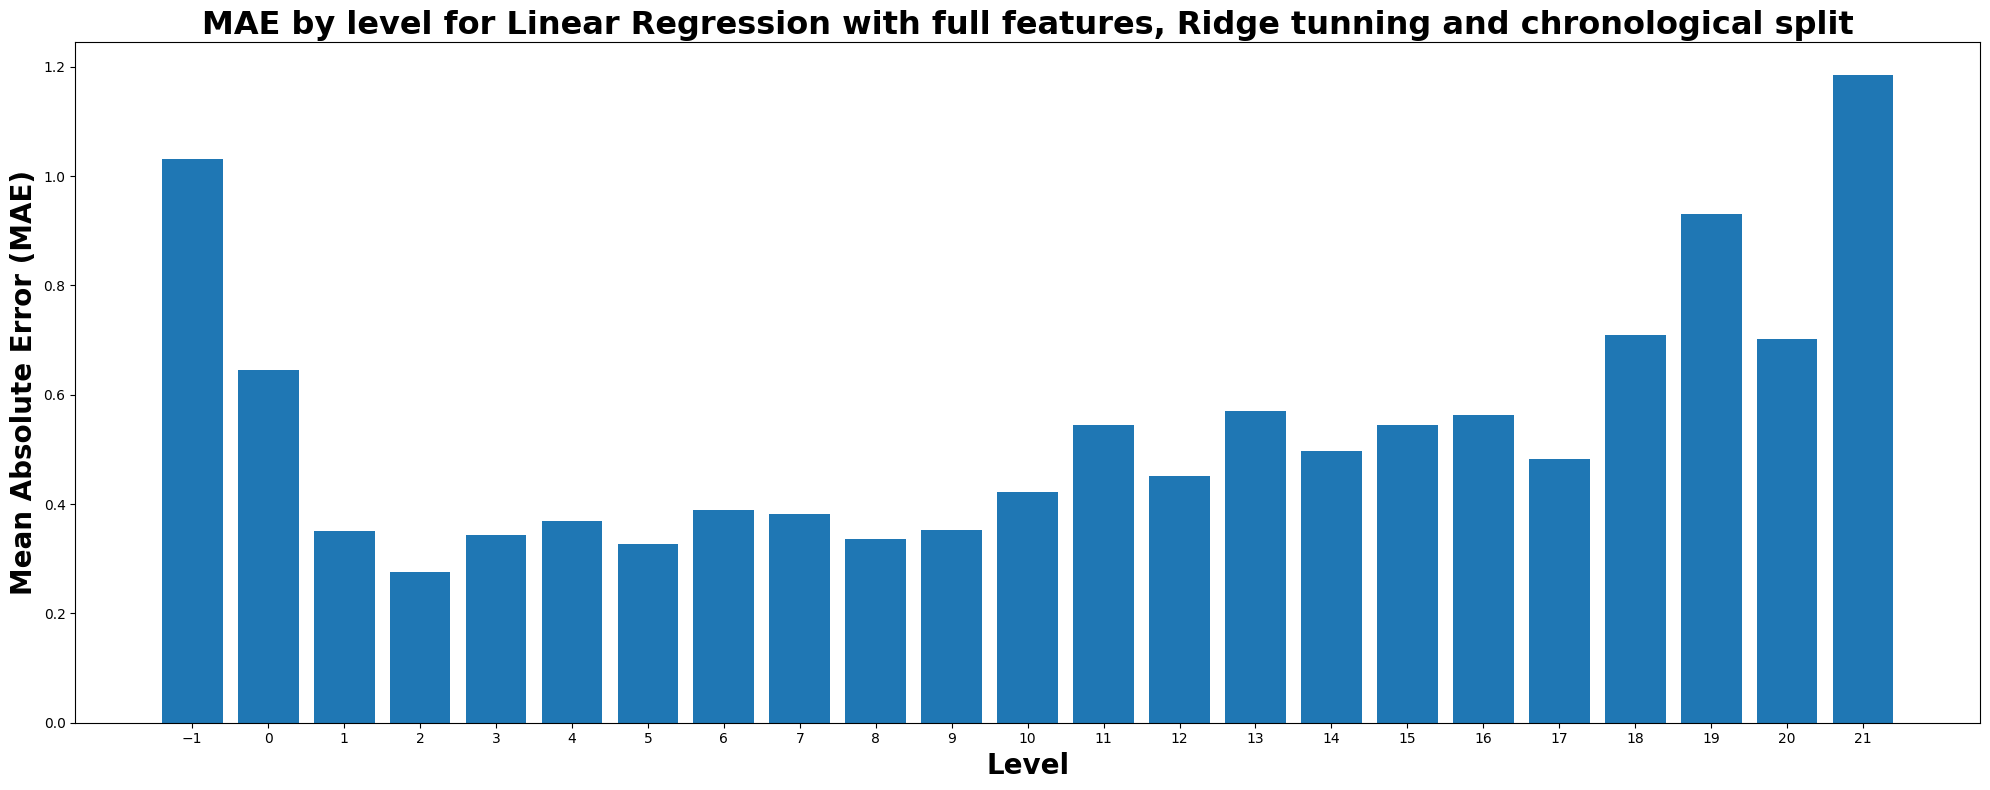

In [33]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for Linear Regression with full features, Ridge tunning and chronological split",
)

###### MAE by level LASSO

In [34]:
y_pred_test = reg_lasso_cv.predict(X_test)

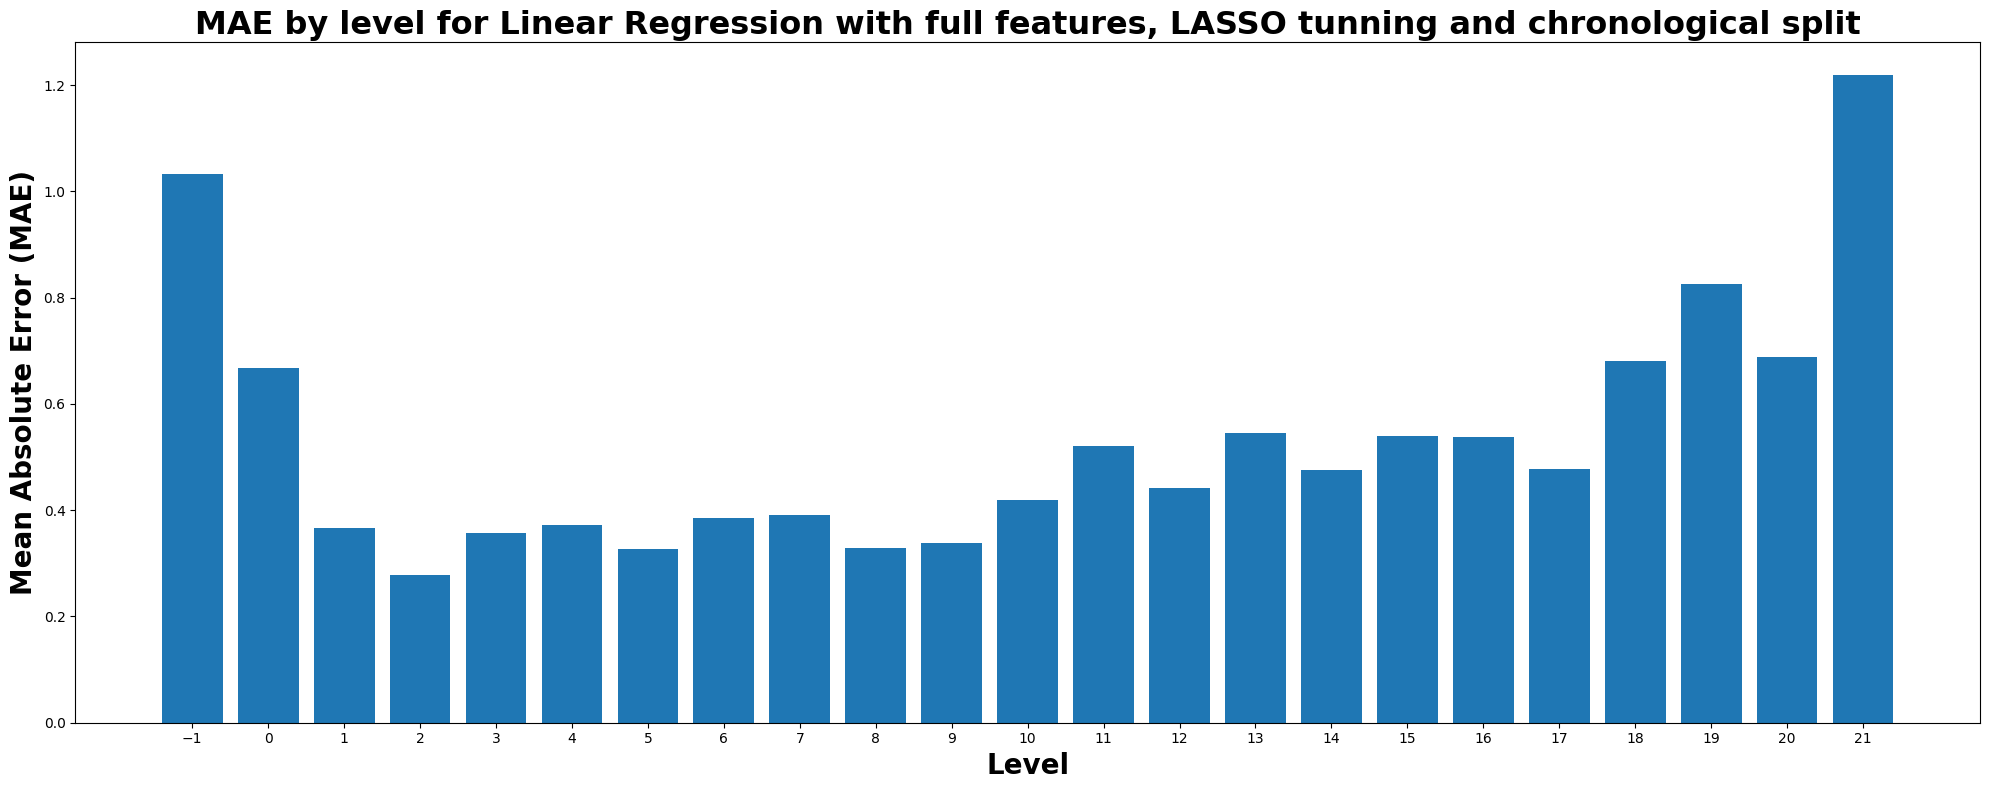

In [35]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for Linear Regression with full features, LASSO tunning and chronological split",
)

<Axes: title={'center': 'Best features'}, ylabel='feature name'>

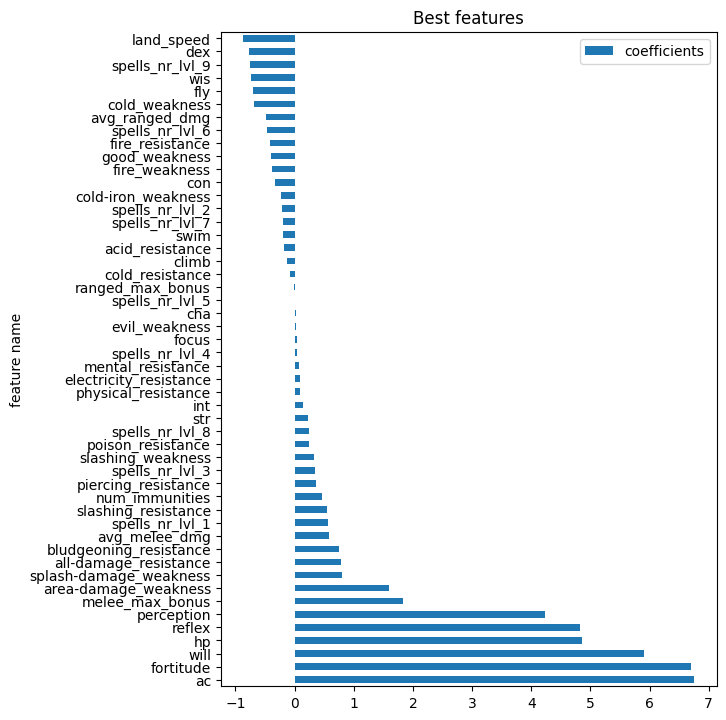

In [36]:
feature_names = X_train.columns

ridgecv_coefficients = pd.DataFrame(
    {
        "feature name": columns,
        "coefficients": reg_ridge_cv.coef_,
    }
)
best_features = ridgecv_coefficients.sort_values("coefficients", ascending=False)
best_features.plot.barh(
    x="feature name", y="coefficients", title="Best features", figsize=(6.4, 8.5)
)

In [37]:
sorted(feature_names[reg_lasso_cv.coef_ == 0])

['acid_resistance',
 'cha',
 'cold_resistance',
 'electricity_resistance',
 'evil_weakness',
 'focus',
 'physical_resistance',
 'ranged_max_bonus',
 'spells_nr_lvl_2',
 'spells_nr_lvl_5',
 'spells_nr_lvl_8',
 'splash-damage_weakness',
 'str']

### With random split

In [38]:
from sklearn.linear_model import RidgeCV, LassoCV

reg_ridge_cv = RidgeCV(alphas=np.linspace(1e-3, 1, 10000))
reg_lasso_cv = LassoCV(alphas=np.linspace(1e-4, 1e-1, 1000), random_state=0)

reg_ridge_cv = reg_ridge_cv.fit(X_train_random_split, y_train_random_split)
reg_lasso_cv = reg_lasso_cv.fit(
    X_train_random_split,
    np.array(y_train_random_split).reshape(
        y_train_random_split.size,
    ),
)

print(f"Ridge CV alphas: {reg_ridge_cv.alpha_:.4f}")
print(f"Lasso CV alpha: {reg_lasso_cv.alpha_:.4f}")
print()
print("Ridge:")
rmse, mae = assess_regression_model(
    reg_ridge_cv,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
    r2=True,
)
results.loc[4] = ["random", "Ridge", "full", rmse, mae]

print("Lasso:")
rmse, mae = assess_regression_model(
    reg_lasso_cv,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
    r2=True,
)
results.loc[5] = ["random", "Lasso", "full", rmse, mae]

Ridge CV alphas: 1.0000
Lasso CV alpha: 0.0017

Ridge:
R2: 0.99
RMSE train: 0.61
RMSE test: 0.58
MAE test: 0.39

Lasso:
R2: 0.99
RMSE train: 0.62
RMSE test: 0.58
MAE test: 0.39



###### MAE by level Ridge

In [39]:
y_pred_test_random_split = reg_ridge_cv.predict(X_test_random_split)

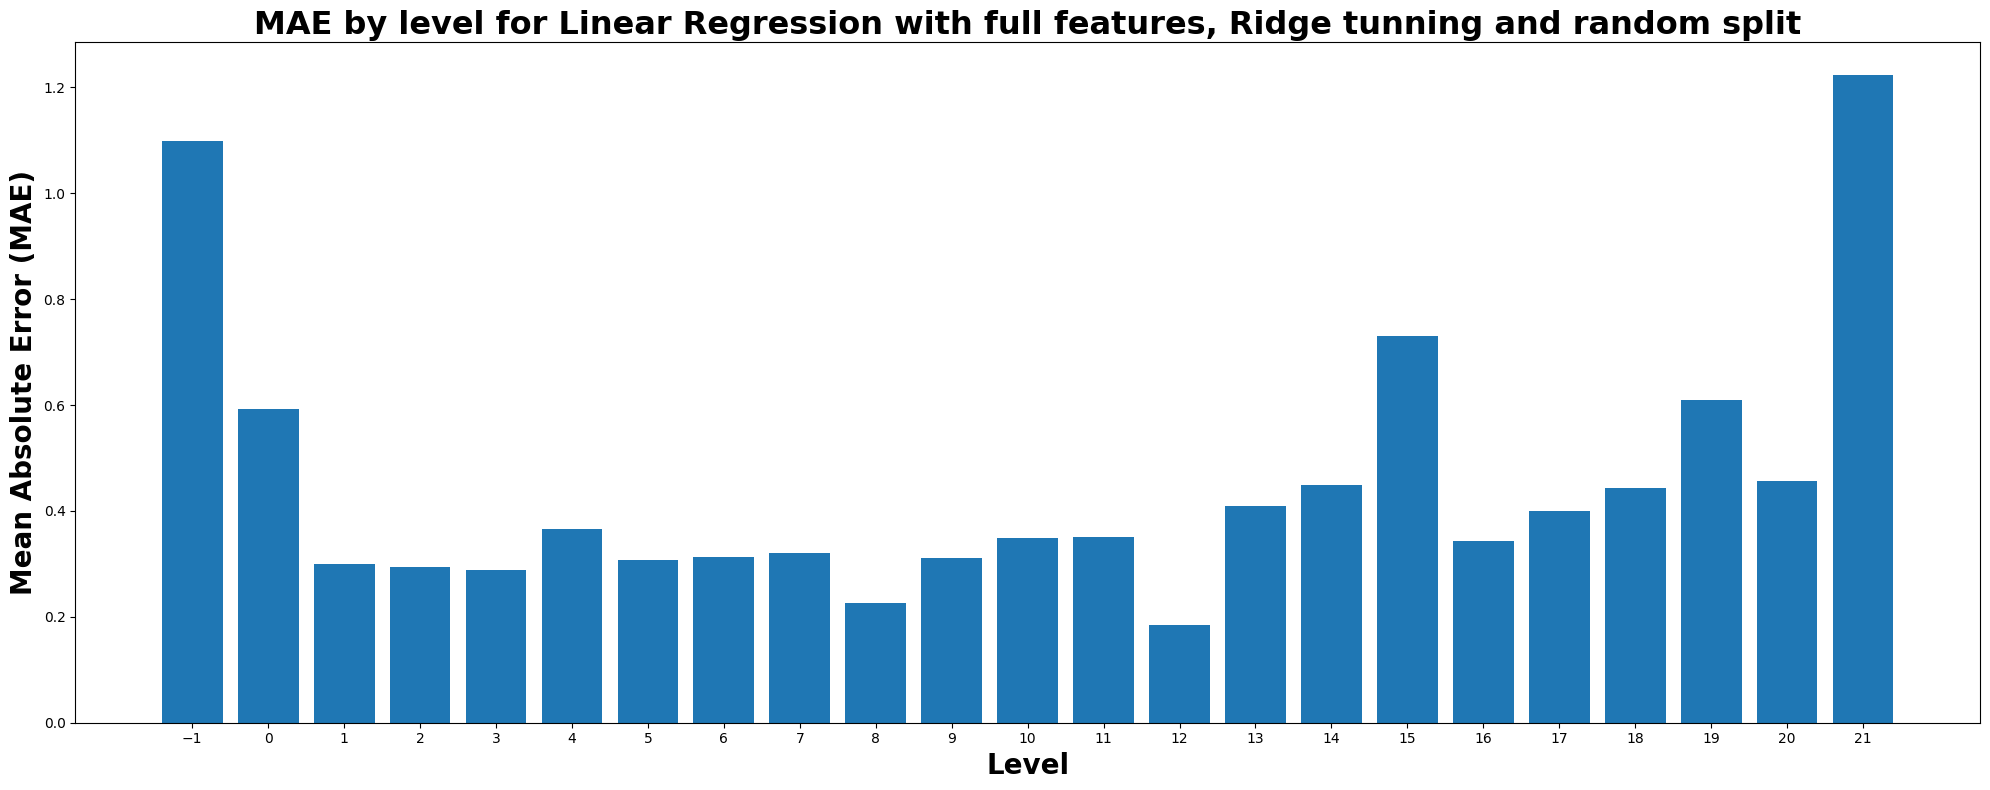

In [40]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test_random_split,
    title="MAE by level for Linear Regression with full features, Ridge tunning and random split",
)

###### MAE by level LASSO

In [41]:
y_pred_test_random_split = reg_lasso_cv.predict(X_test_random_split)

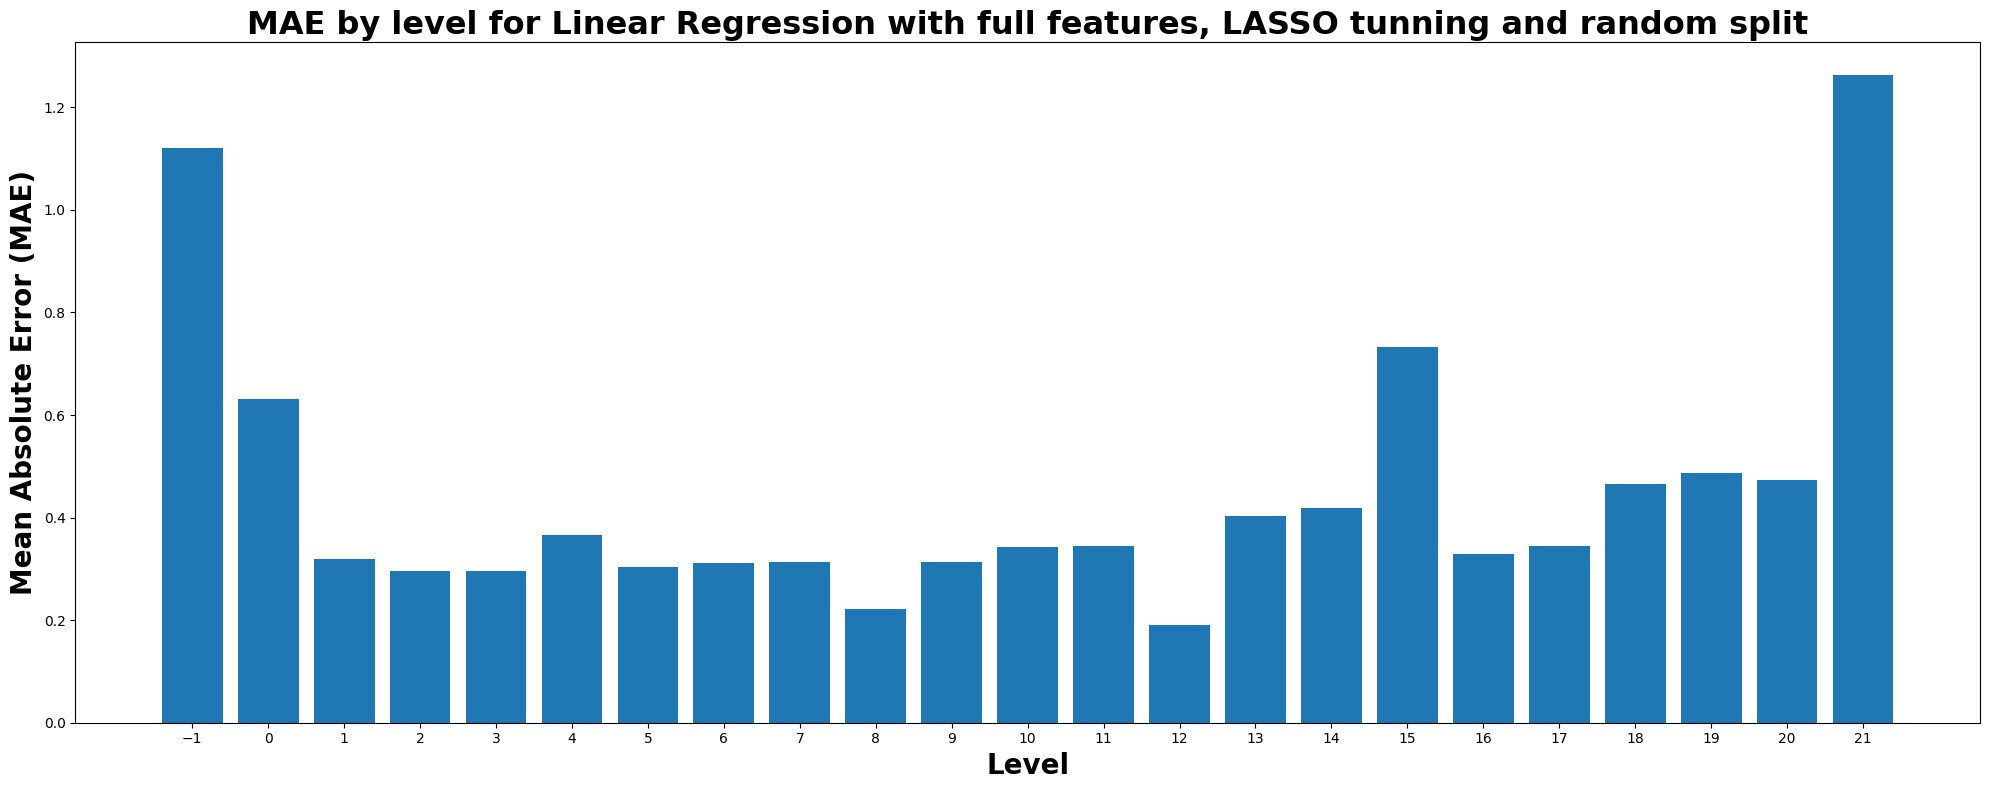

In [42]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test_random_split,
    title="MAE by level for Linear Regression with full features, LASSO tunning and random split",
)

<Axes: title={'center': 'Best features'}, ylabel='feature name'>

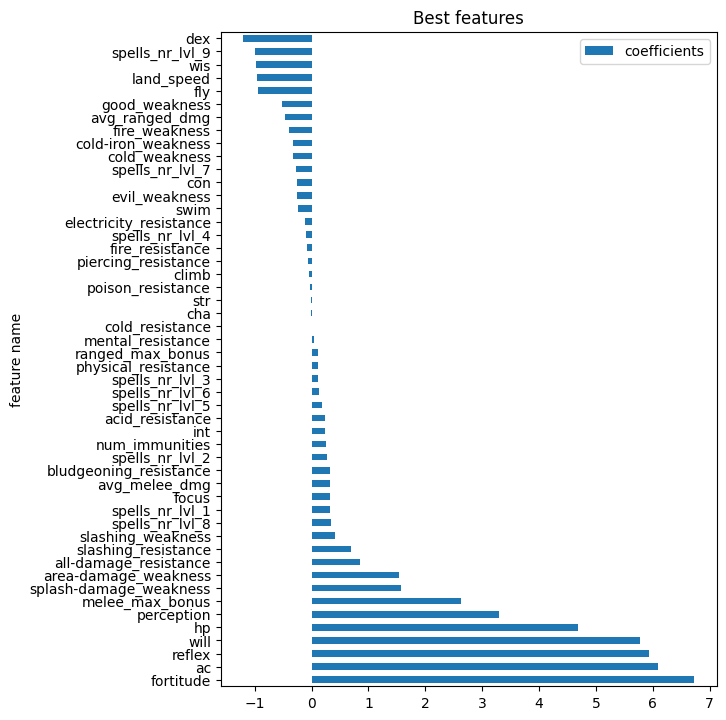

In [43]:
feature_names = X_train.columns

ridgecv_coefficients = pd.DataFrame(
    {
        "feature name": columns,
        "coefficients": reg_ridge_cv.coef_,
    }
)
best_features = ridgecv_coefficients.sort_values("coefficients", ascending=False)
best_features.plot.barh(
    x="feature name", y="coefficients", title="Best features", figsize=(6.4, 8.5)
)

In [44]:
eliminated_features = sorted(feature_names[reg_lasso_cv.coef_ == 0])
print(eliminated_features)

['acid_resistance', 'avg_melee_dmg', 'bludgeoning_resistance', 'cha', 'climb', 'cold_resistance', 'electricity_resistance', 'evil_weakness', 'fire_resistance', 'mental_resistance', 'physical_resistance', 'piercing_resistance', 'poison_resistance', 'ranged_max_bonus', 'spells_nr_lvl_4', 'spells_nr_lvl_6', 'spells_nr_lvl_7', 'spells_nr_lvl_8']


## Summary

In [45]:
results

,Split type,Tuning type,Set of features,RMSE,MAE
0,chronological,default,full,0.681864,0.453925
1,random,default,full,0.575622,0.393046
2,chronological,Ridge,full,0.669241,0.456010
3,chronological,Lasso,full,0.668474,0.453311
4,random,Ridge,full,0.575968,0.389740
5,random,Lasso,full,0.576012,0.389817


In [46]:
from training.results import plot_summary

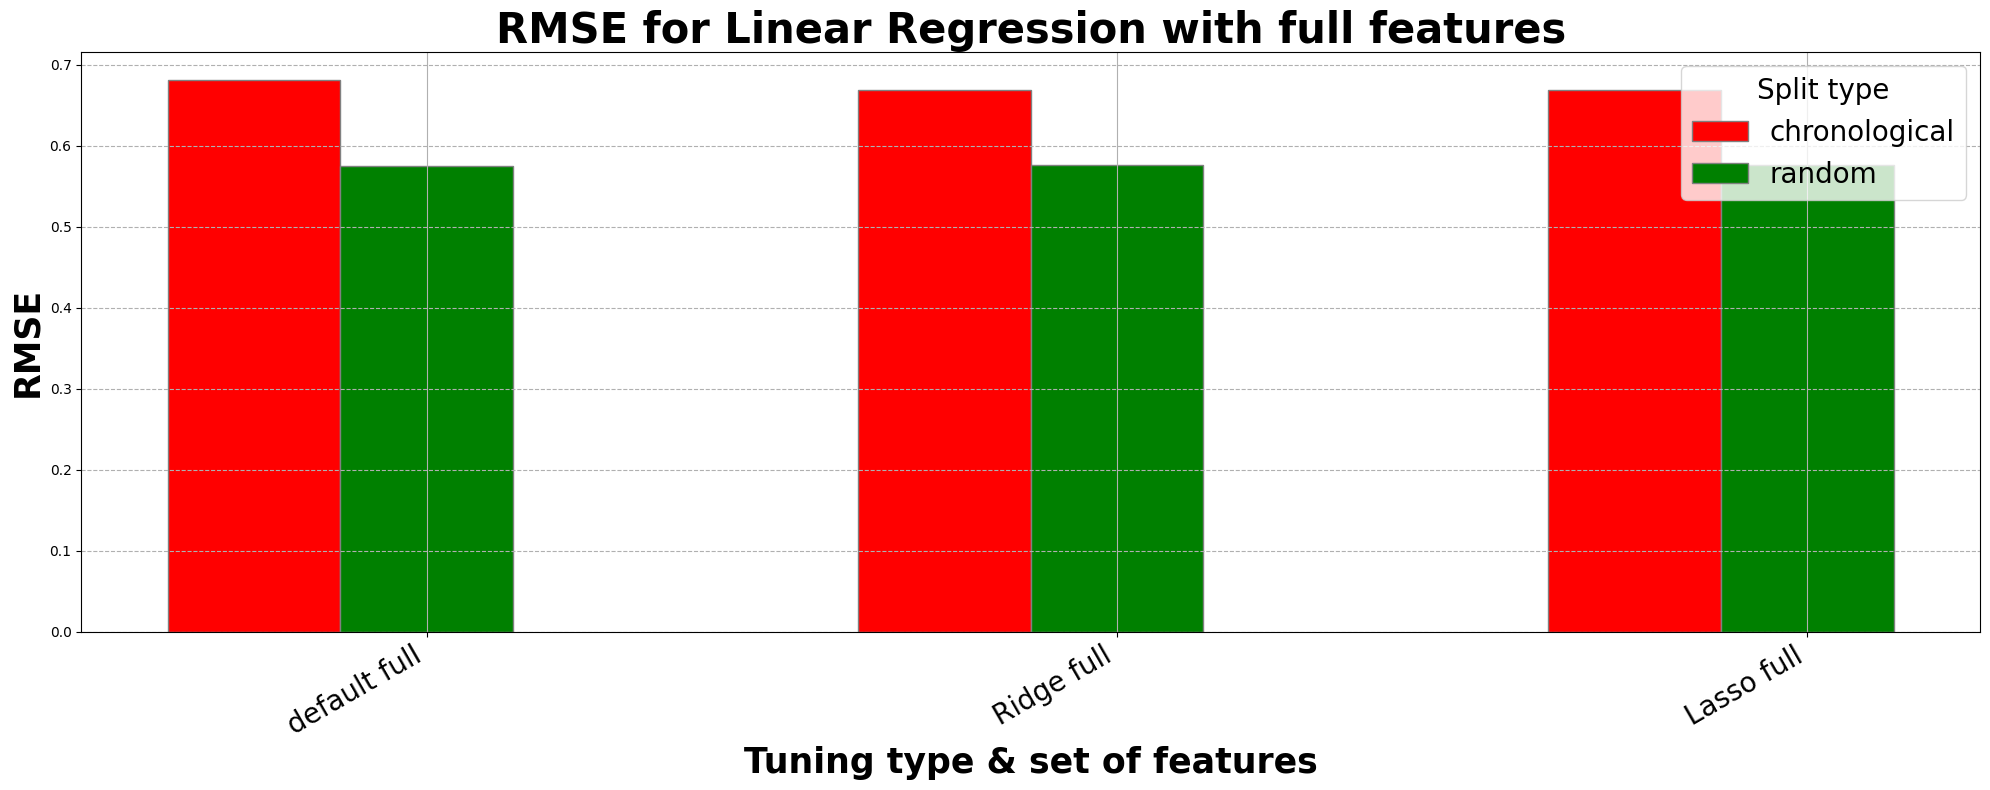

In [47]:
plot_summary(results, "RMSE", title="RMSE for Linear Regression with full features")

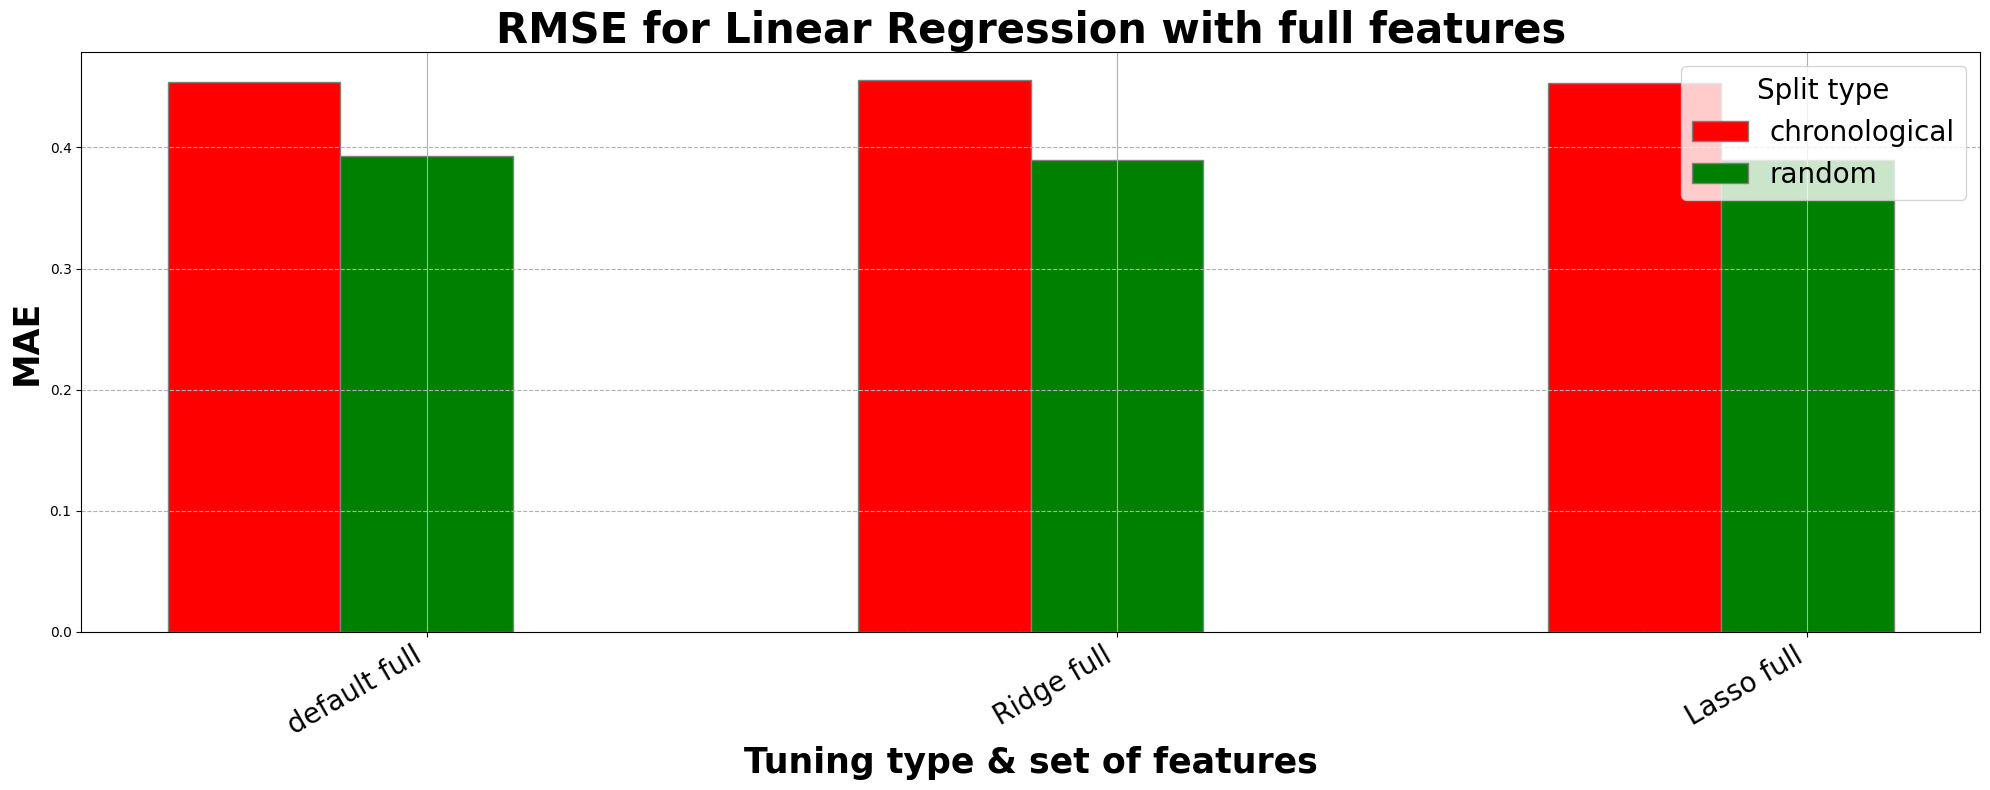

In [48]:
plot_summary(results, "MAE", title="RMSE for Linear Regression with full features")

In [49]:
results.to_csv("./linear_regression_full_results.csv")